# MIRI Internal Calibration Source Observations
Though the MTS extended, point source, and etalon data have their fair share of information to share, these are all optical stimuli placed outside of MIRI, observed during a test campaigns on-ground. As such they will not be available to be tested for repeatability during in-flight operations. Here we examine the MIRI internal calibration source observations. This source will also be observed periodically in-flight, thus understanding its behavior, as a "standard" of sorts, is important both in the context of flat-fielding the detector, but also in the context of MIRI fringes. Obviously the light from the MIRI calibration source will also yield a fringe spectrum.

## > Import modules

In [2]:
import funcs
import mrsobs

import numpy as np
from matplotlib import pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

## > Get data
We load the images for one band of the MRS for different kinds of sources, including: 
* MTS 800K BB extended source
* MIRI 800K BB internal calibration source
* MTS 800K BB extended source observed through 100micron pinhole 
  
Additionally the pixel-to-wavelength calibration map and the pixel-to-along-slice position map are imported.

In [43]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

# Get data
band = '1A'
ext_source_sci,ext_source_bkg           = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K')
intcal_source_sci                       = mrsobs.MIRI_internal_calibration_source(lvl2path,band,campaign='FM')
point_source_sci_p1,point_source_bkg_p1 = mrsobs.FM_MTS_800K_BB_point_source_raster(lvl2path,position='middle',pointing='P3')

# Get wavelength calibration pixel map
d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
lambdaMap = d2cMaps['lambdaMap']
sliceMap  = d2cMaps['sliceMap']
nslices   = d2cMaps['nslices']

# Get spectral resolution table
specres_table = funcs.get_cdps(cdpDir=cdpDir,band=band)[4]

## > Transform data
We subtract background exposures where available.

In [4]:
# perform transform
ext_source_bkgsubtr      = ext_source_sci-ext_source_bkg
point_source_p1_bkgsubtr = point_source_sci_p1-point_source_bkg_p1

We perform an even-odd row signal correction to the data (caused by the read-out pattern of MIRI detector pixel rows).

In [5]:
ext_source_oddevencorr      = funcs.OddEvenRowSignalCorrection(ext_source_bkgsubtr)
intcal_source_oddevencorr   = funcs.OddEvenRowSignalCorrection(intcal_source_sci)
point_source_p1_oddevencorr = funcs.OddEvenRowSignalCorrection(point_source_p1_bkgsubtr)

## > Modeling
From MIRI design description report MIRI-DD-00001-AEU:
"*The calibration system consists of two identical calibration sources for flat-fielding the MIRIM detector array and for flat-fielding the spectrometer detector arrays. The blackbody radiation is produced by micro-miniature tungsten filament lamps and is rendered uniform by a diffusing surface within an optical concentrator. The light is then re-imaged to a pupil placed in the shadow of the secondary mirror.*"
### Test 1: How flat is the internal calibration source spectrum? How does it compare to the MTS extended source?

<IPython.core.display.Javascript object>


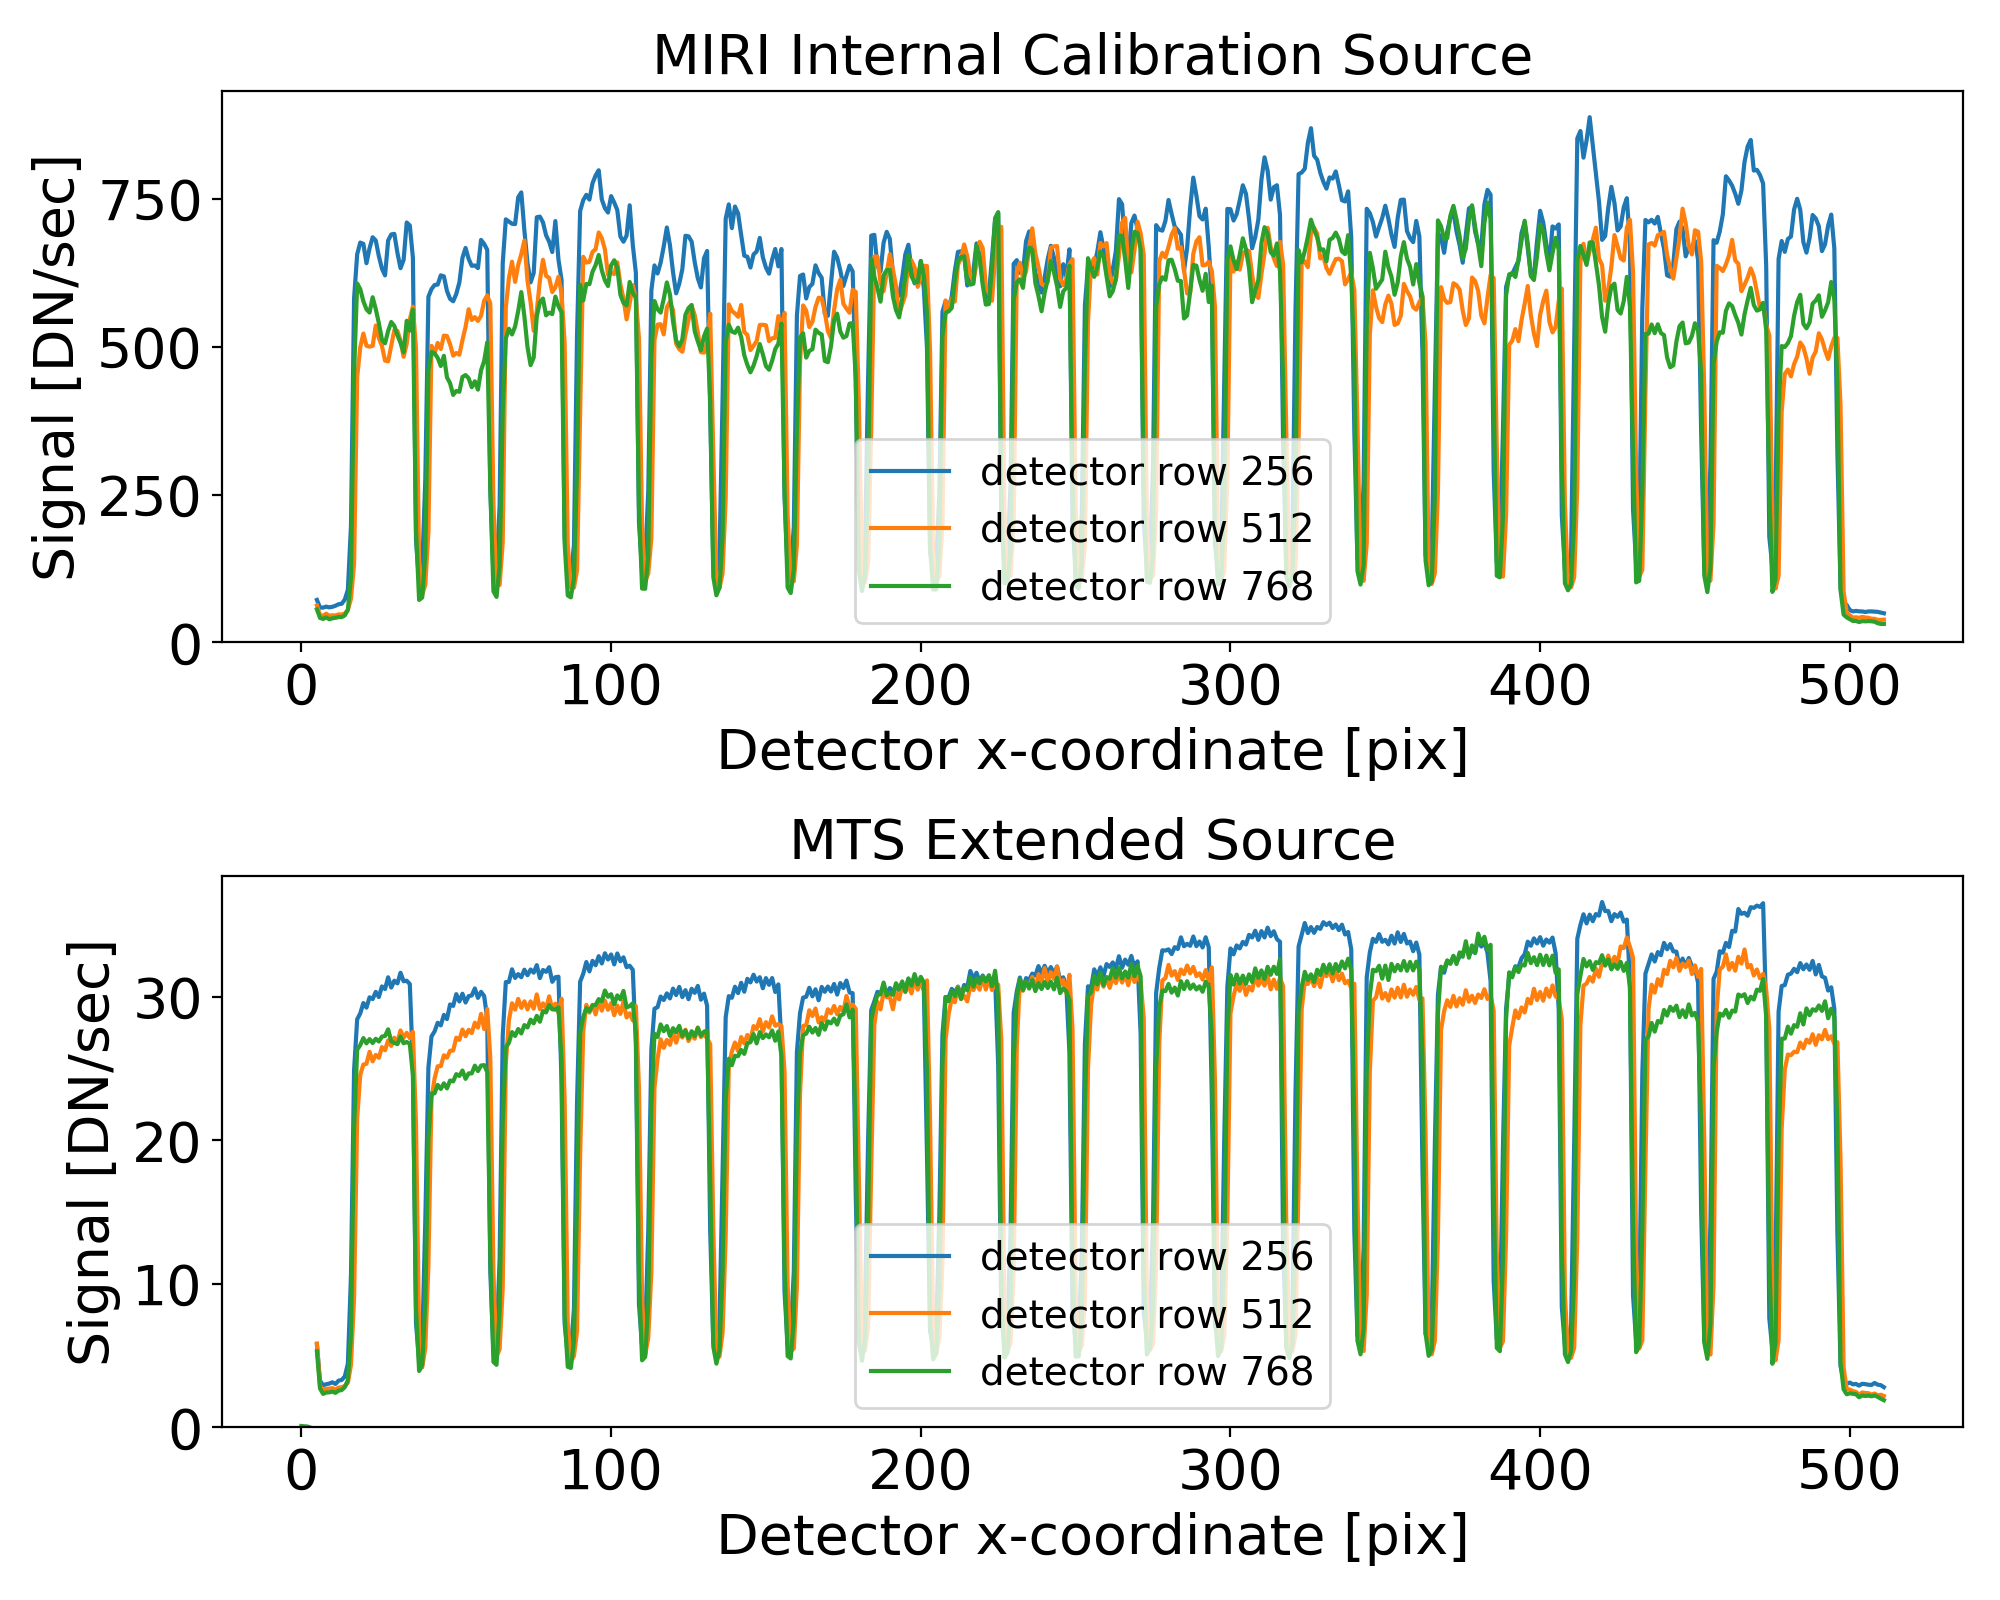

In [6]:
fig,axs = plt.subplots(2,1,figsize=(10,8))
for row in [255,511,767]:
    axs[0].plot(intcal_source_oddevencorr[row,:512],label='detector row {}'.format(row+1))
    axs[1].plot(ext_source_oddevencorr[row,:512],label='detector row {}'.format(row+1))
axs[0].set_title('MIRI Internal Calibration Source')
axs[1].set_title('MTS Extended Source')
for plot in range(2):
    axs[plot].set_ylim(0)
    axs[plot].set_xlabel('Detector x-coordinate [pix]')
    axs[plot].set_ylabel('Signal [DN/sec]')
    axs[plot].legend(loc='lower center')
plt.tight_layout()

### Remarks:
* The internal calibration source spectrum has spatial structure, as illustrated by the distinct peaks and troughs in spatial direction (detector x-coordinate). These peaks and troughs are identical in three different detector rows, hence three different wavelengths. 
* The spatial structure of the internal calibration source implies that, if one were to not be careful with the pixel trace taken through a slice, considerable jumps in signal would be observed from one wavelength to the next, despite presumably (/wrongly assuming) that one is looking at the "same" spatial position in the slice.
* The internal calibration source signal is much higher than the MTS extended source signal (presumably because the optical train for the internal calibration source light contains much fewer optical components?). The internal calibration source signal is 20 times larger than the MTS extended source signal. Is this justified by the transmission of the optics?
* The MTS extended source spectrum is much flatter than the internal calibration source spectrum, presumably thanks to the comparatively better performance of the integrating sphere of the MTS, compared to the "diffusing surface of the optical concentrator" of MIRI.

### Test 2: How do the internal calibration source observations compare between test campaigns?
Read-out mode for all observations: NFRAME=1, NGROUP=20, NINT=5, READOUT=FAST

In [7]:
CV3_lvl2path  = workDir+'CV3_data/LVL2/'
FM_lvl2path   = workDir+'FM_data/LVL2/'
OTIS_lvl2path = workDir+'OTIS_data/MRS_RAD_11_CPT/'

CV3_intcal_source_sci = mrsobs.MIRI_internal_calibration_source(CV3_lvl2path,band,campaign='CV3')
FM_intcal_source_sci = mrsobs.MIRI_internal_calibration_source(FM_lvl2path,band,campaign='FM')
OTIS_intcal_source_sci = mrsobs.MIRI_internal_calibration_source(OTIS_lvl2path,band,campaign='OTIS')

CV3_intcal_source_oddevencorr = funcs.OddEvenRowSignalCorrection(CV3_intcal_source_sci)
FM_intcal_source_oddevencorr = funcs.OddEvenRowSignalCorrection(FM_intcal_source_sci)
OTIS_intcal_source_oddevencorr = funcs.OddEvenRowSignalCorrection(OTIS_intcal_source_sci)

<IPython.core.display.Javascript object>


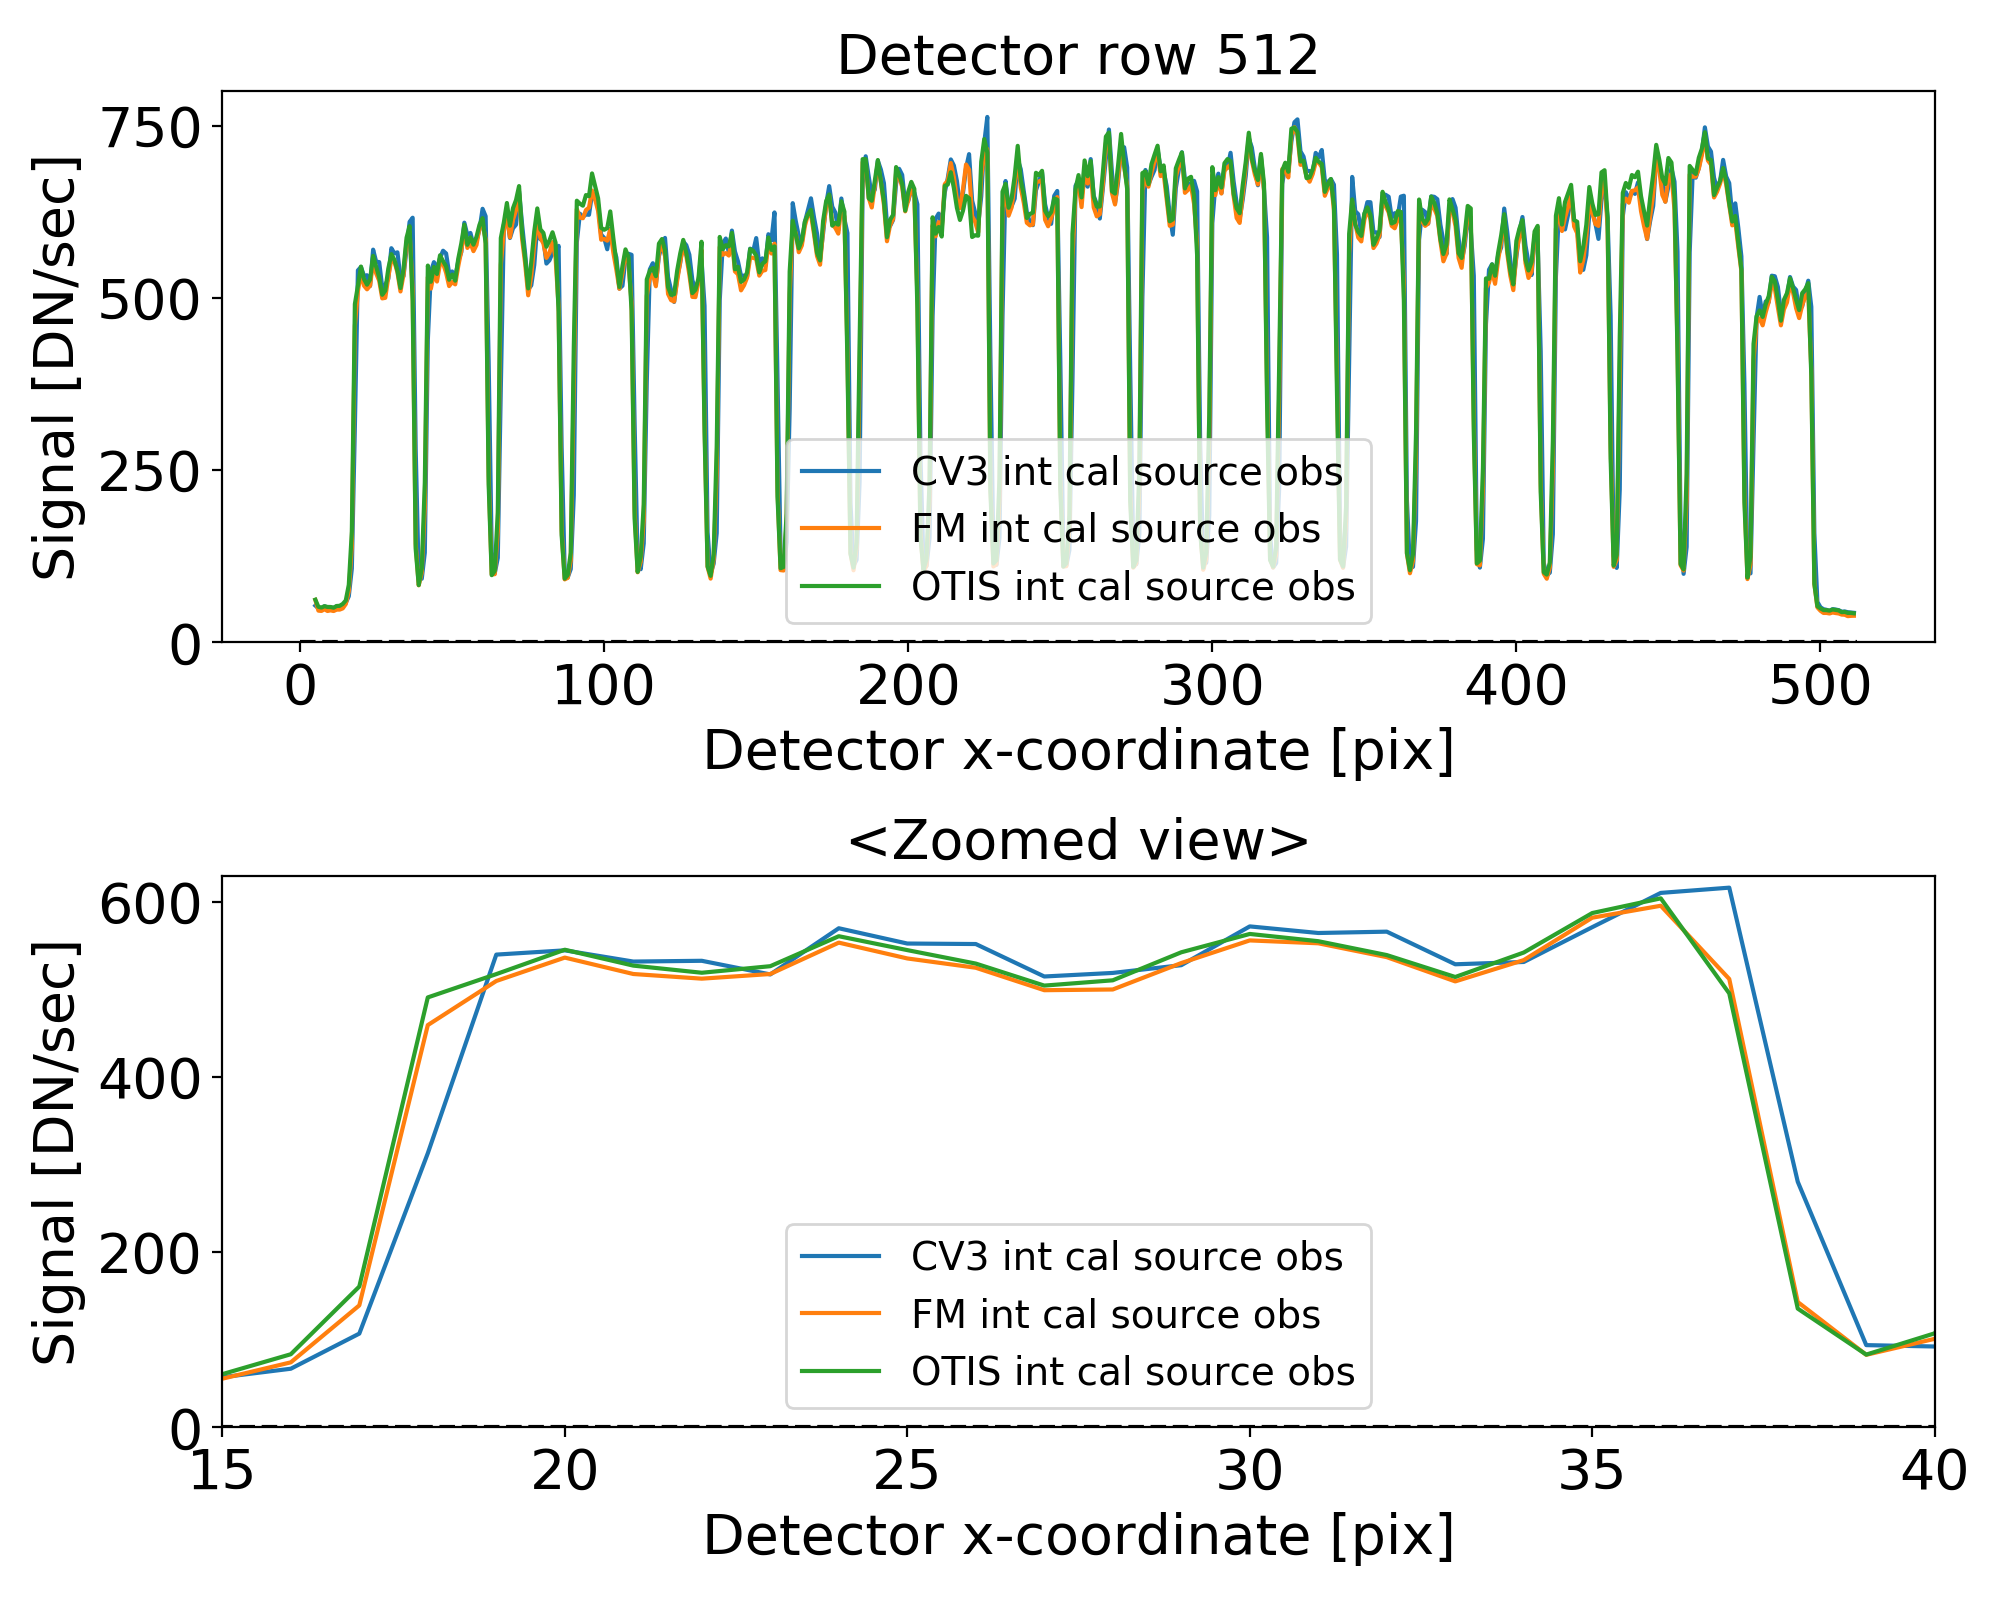

<IPython.core.display.Javascript object>


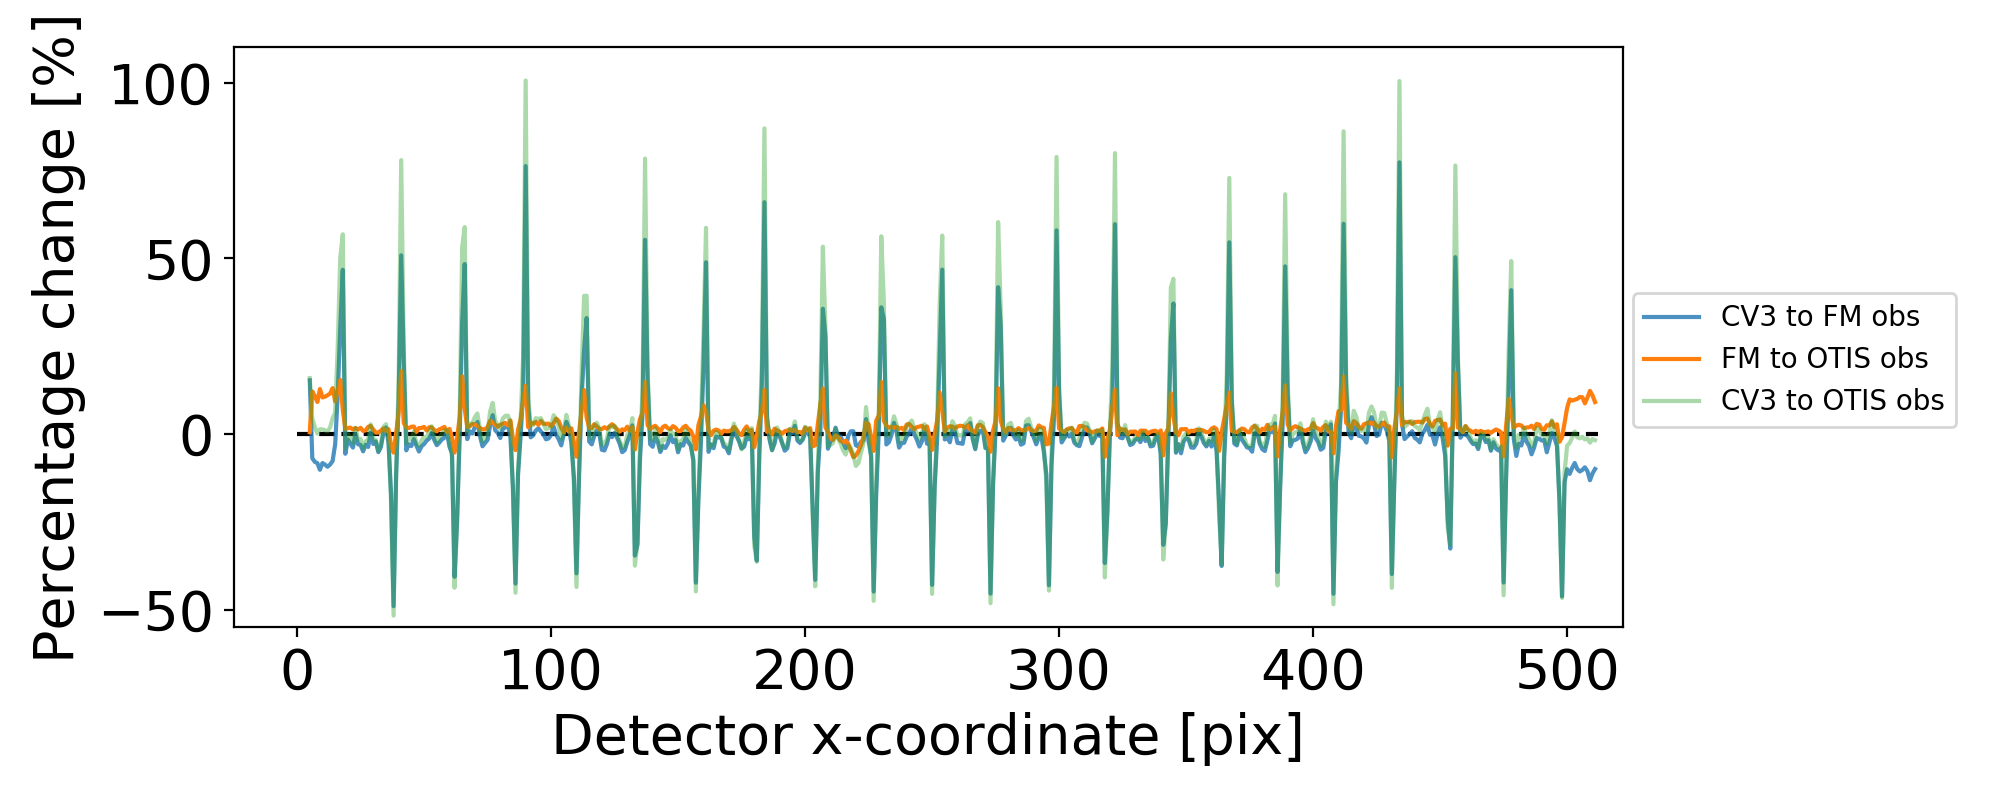

In [8]:
row = 512
fig,axs = plt.subplots(2,1,figsize=(10,8))
axs[0].set_title('Detector row 512')
for plot in range(2):
    axs[plot].plot(CV3_intcal_source_oddevencorr[row,:512],label='CV3 int cal source obs')
    axs[plot].plot(FM_intcal_source_oddevencorr[row,:512],label='FM int cal source obs')
    axs[plot].plot(OTIS_intcal_source_oddevencorr[row,:512],label='OTIS int cal source obs')
    axs[plot].hlines(0,0,512,linestyle='dashed')
    axs[plot].set_ylim(0)
    axs[plot].set_xlabel('Detector x-coordinate [pix]')
    axs[plot].set_ylabel('Signal [DN/sec]')
    axs[plot].legend(loc='lower center')
axs[1].set_title('<Zoomed view>')
axs[1].set_xlim(15,40)
axs[1].set_ylim(0,630)
plt.tight_layout()

row = 512
plt.figure(figsize=(10,4))
plt.plot((FM_intcal_source_oddevencorr[row,:512]/CV3_intcal_source_oddevencorr[row,:512] -1)*100.,alpha=0.8,label='CV3 to FM obs')
plt.plot((OTIS_intcal_source_oddevencorr[row,:512]/FM_intcal_source_oddevencorr[row,:512] -1)*100.,label='FM to OTIS obs')
plt.plot((OTIS_intcal_source_oddevencorr[row,:512]/CV3_intcal_source_oddevencorr[row,:512] -1)*100.,alpha=0.4,label='CV3 to OTIS obs')
plt.hlines(0,0,512,linestyle='dashed')
plt.xlim(-25,522)
plt.ylim(-55,110)
plt.xlabel('Detector x-coordinate [pix]')
plt.ylabel('Percentage change [%]')
plt.legend(loc='upper right',fontsize=10,bbox_to_anchor=(1.25,0.6))
plt.tight_layout(rect=[0,0,0.83,1])

### Remarks:
* There seems to be a spatial discrepancy between the slice data in the CV3, FM, and OTIS test campaign, however the discrepancy is only apparent at the slice edges. The discrepancy is smaller for the FM to OTIS transition compared to the CV3 to FM transition or the CV3 to OTIS transition. The latter two are similar in extent.
* We know that between test campaigns (cool-down, warm-up, cool-down) the grating stability in spatial direction is worse than in spectral direction (private communication, Alister Glasse). Is this the cause of what we see here?
* Despite the Contamination Control Cover (CCC) being closed for all three of the internal calibration source observations, the background (amount of straylight?) is smaller for the FM observation compared to the CV3 and OTIS observations, which have similarly larger values. Could a correction for the amount of straylight make the three observations agree?

### Test 3: Correcting for straylight
We use the straylight correction algorithm developed by Adrian Glauser (ETH Zurich) as a quick check on whether the differentiating background between test campaigns could be due to different levels of straylight.

In [9]:
CV3_intcal_source_straylightcorr  = funcs.straylightCorrection(CV3_intcal_source_oddevencorr,sliceMap)
FM_intcal_source_straylightcorr   = funcs.straylightCorrection(FM_intcal_source_oddevencorr,sliceMap)
OTIS_intcal_source_straylightcorr = funcs.straylightCorrection(OTIS_intcal_source_oddevencorr,sliceMap)

<IPython.core.display.Javascript object>


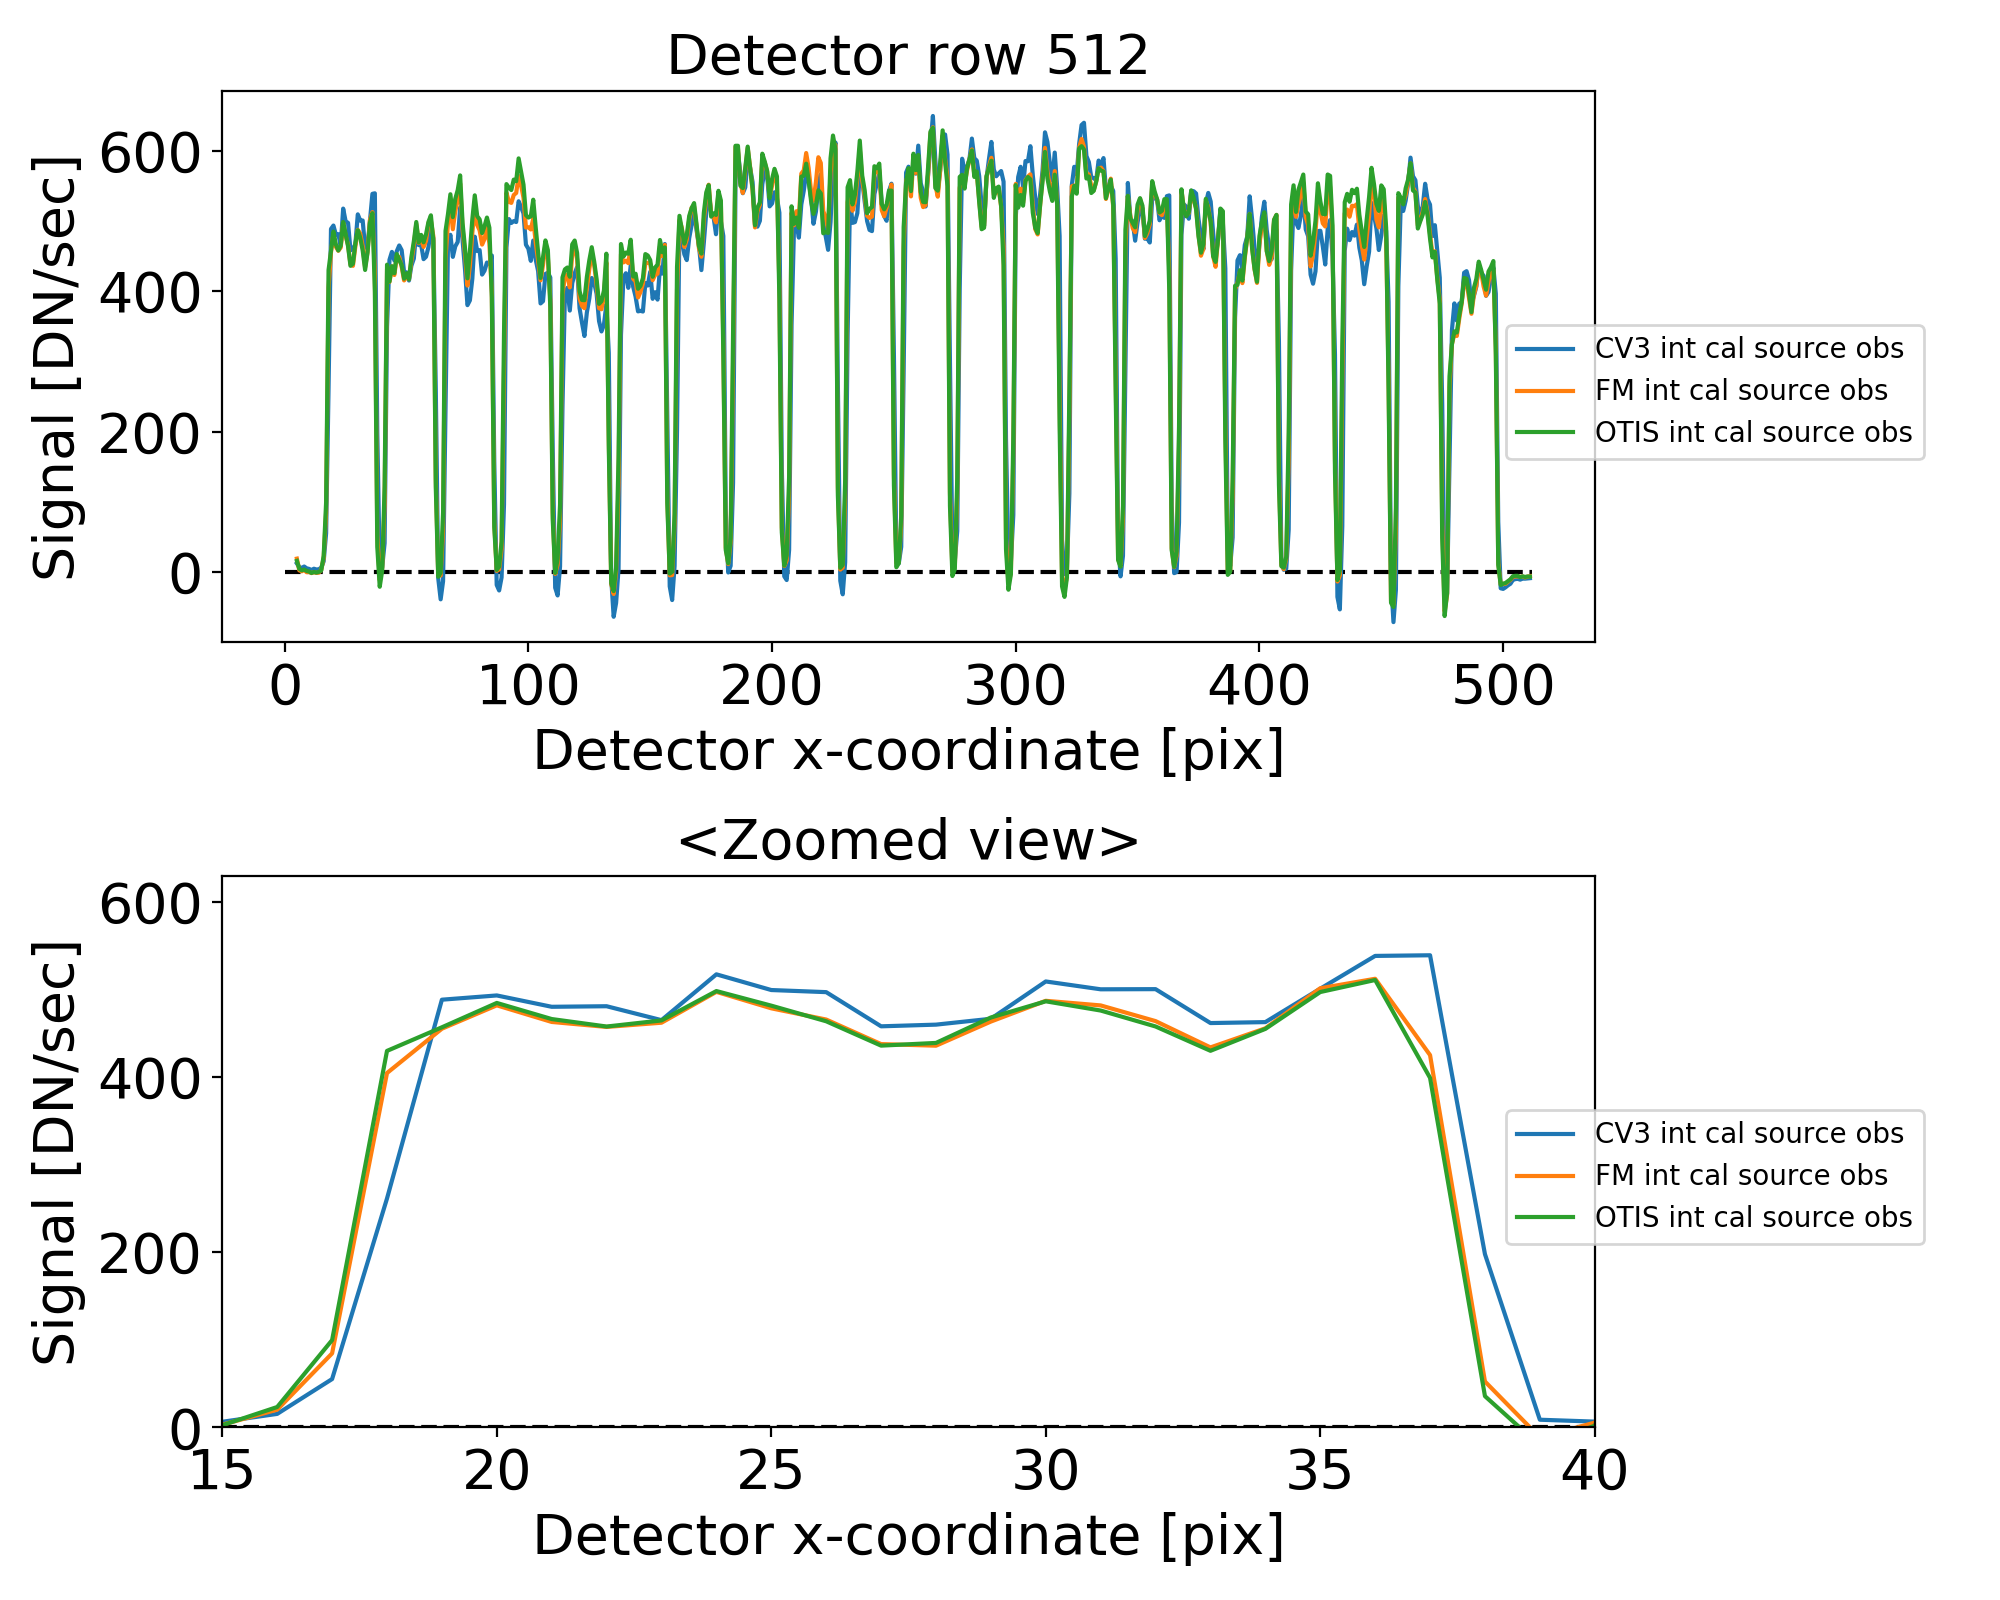

<IPython.core.display.Javascript object>


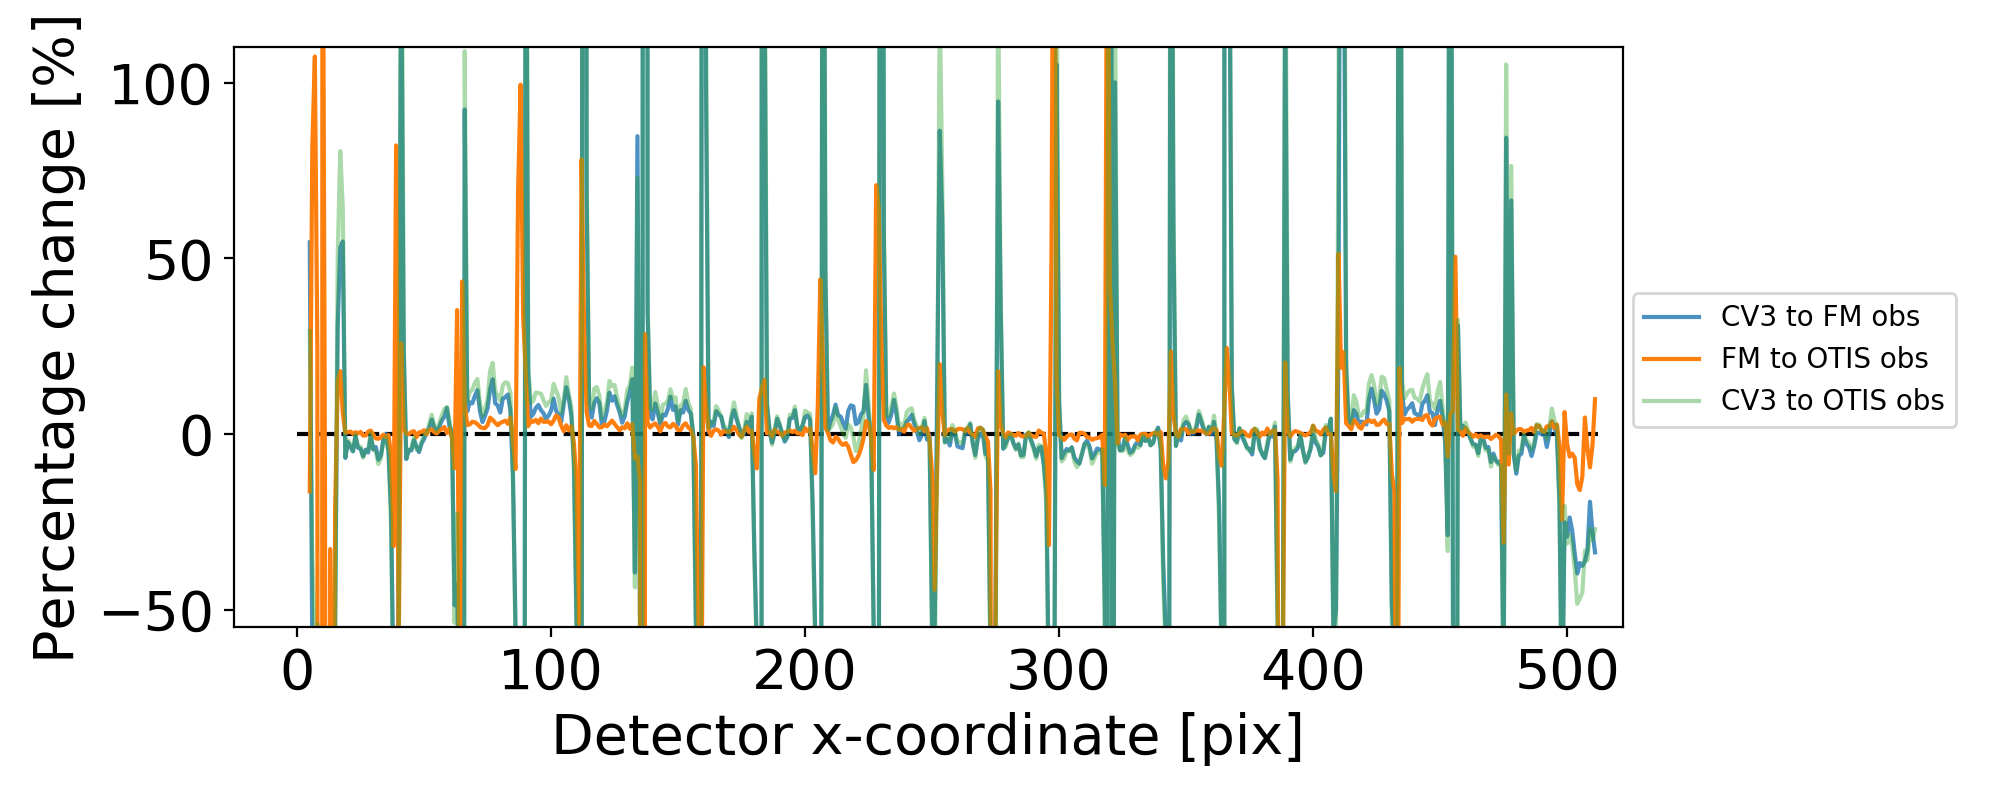

In [10]:
row = 512
fig,axs = plt.subplots(2,1,figsize=(10,8))
axs[0].set_title('Detector row 512')
for plot in range(2):
    axs[plot].plot(CV3_intcal_source_straylightcorr[row,:512],label='CV3 int cal source obs')
    axs[plot].plot(FM_intcal_source_straylightcorr[row,:512],label='FM int cal source obs')
    axs[plot].plot(OTIS_intcal_source_straylightcorr[row,:512],label='OTIS int cal source obs')
    axs[plot].hlines(0,0,512,linestyle='dashed')
    axs[plot].set_ylim(-100)
    axs[plot].set_xlabel('Detector x-coordinate [pix]')
    axs[plot].set_ylabel('Signal [DN/sec]')
    axs[plot].legend(loc='upper right',fontsize=10,bbox_to_anchor=(1.25,0.6))
axs[1].set_title('<Zoomed view>')
axs[1].set_xlim(15,40)
axs[1].set_ylim(0,630)
plt.tight_layout(rect=[0,0,0.83,1])

row = 512
plt.figure(figsize=(10,4))
plt.plot((FM_intcal_source_straylightcorr[row,:512]/CV3_intcal_source_straylightcorr[row,:512] -1)*100.,alpha=0.8,label='CV3 to FM obs')
plt.plot((OTIS_intcal_source_straylightcorr[row,:512]/FM_intcal_source_straylightcorr[row,:512] -1)*100.,label='FM to OTIS obs')
plt.plot((OTIS_intcal_source_straylightcorr[row,:512]/CV3_intcal_source_straylightcorr[row,:512] -1)*100.,alpha=0.4,label='CV3 to OTIS obs')
plt.hlines(0,0,512,linestyle='dashed')
plt.xlim(-25,522)
plt.ylim(-55,110)
plt.xlabel('Detector x-coordinate [pix]')
plt.ylabel('Percentage change [%]')
plt.legend(loc='upper right',fontsize=10,bbox_to_anchor=(1.25,0.6))
plt.tight_layout(rect=[0,0,0.83,1])

### Remarks:
* The straylight correction increases the difference between test campaigns within the slices. Due to working with values close to zero at the slice edges the difference there becomes unstable.
* The discrepancy of the background between test campaigns does not seem to be reconciled. Thus the question remains as for what is causing the different signal levels.

### Test 4: What do the internal calibration source fringes look like?
To ensure that we are looking at the same spatial position of the calibration source illumination, we base our detector pixel tracing on a point source observation rather than the d2c along-slice information.

In [ ]:
# pixel trace
ypos_p,xpos_p   = funcs.detpixel_trace_compactsource(point_source_p1_oddevencorr,band,d2cMaps)

# signal normalization based on fringe profile
sel = lambdaMap[ypos_p,xpos_p]!=0
intcal_source_norm = funcs.norm_fringe(intcal_source_sci[ypos_p,xpos_p][sel],thres=0.,min_dist=6,k=3,ext=3)
ext_source_norm = funcs.norm_fringe(ext_source_oddevencorr[ypos_p,xpos_p][sel],thres=0.,min_dist=6,k=3,ext=3)

<IPython.core.display.Javascript object>


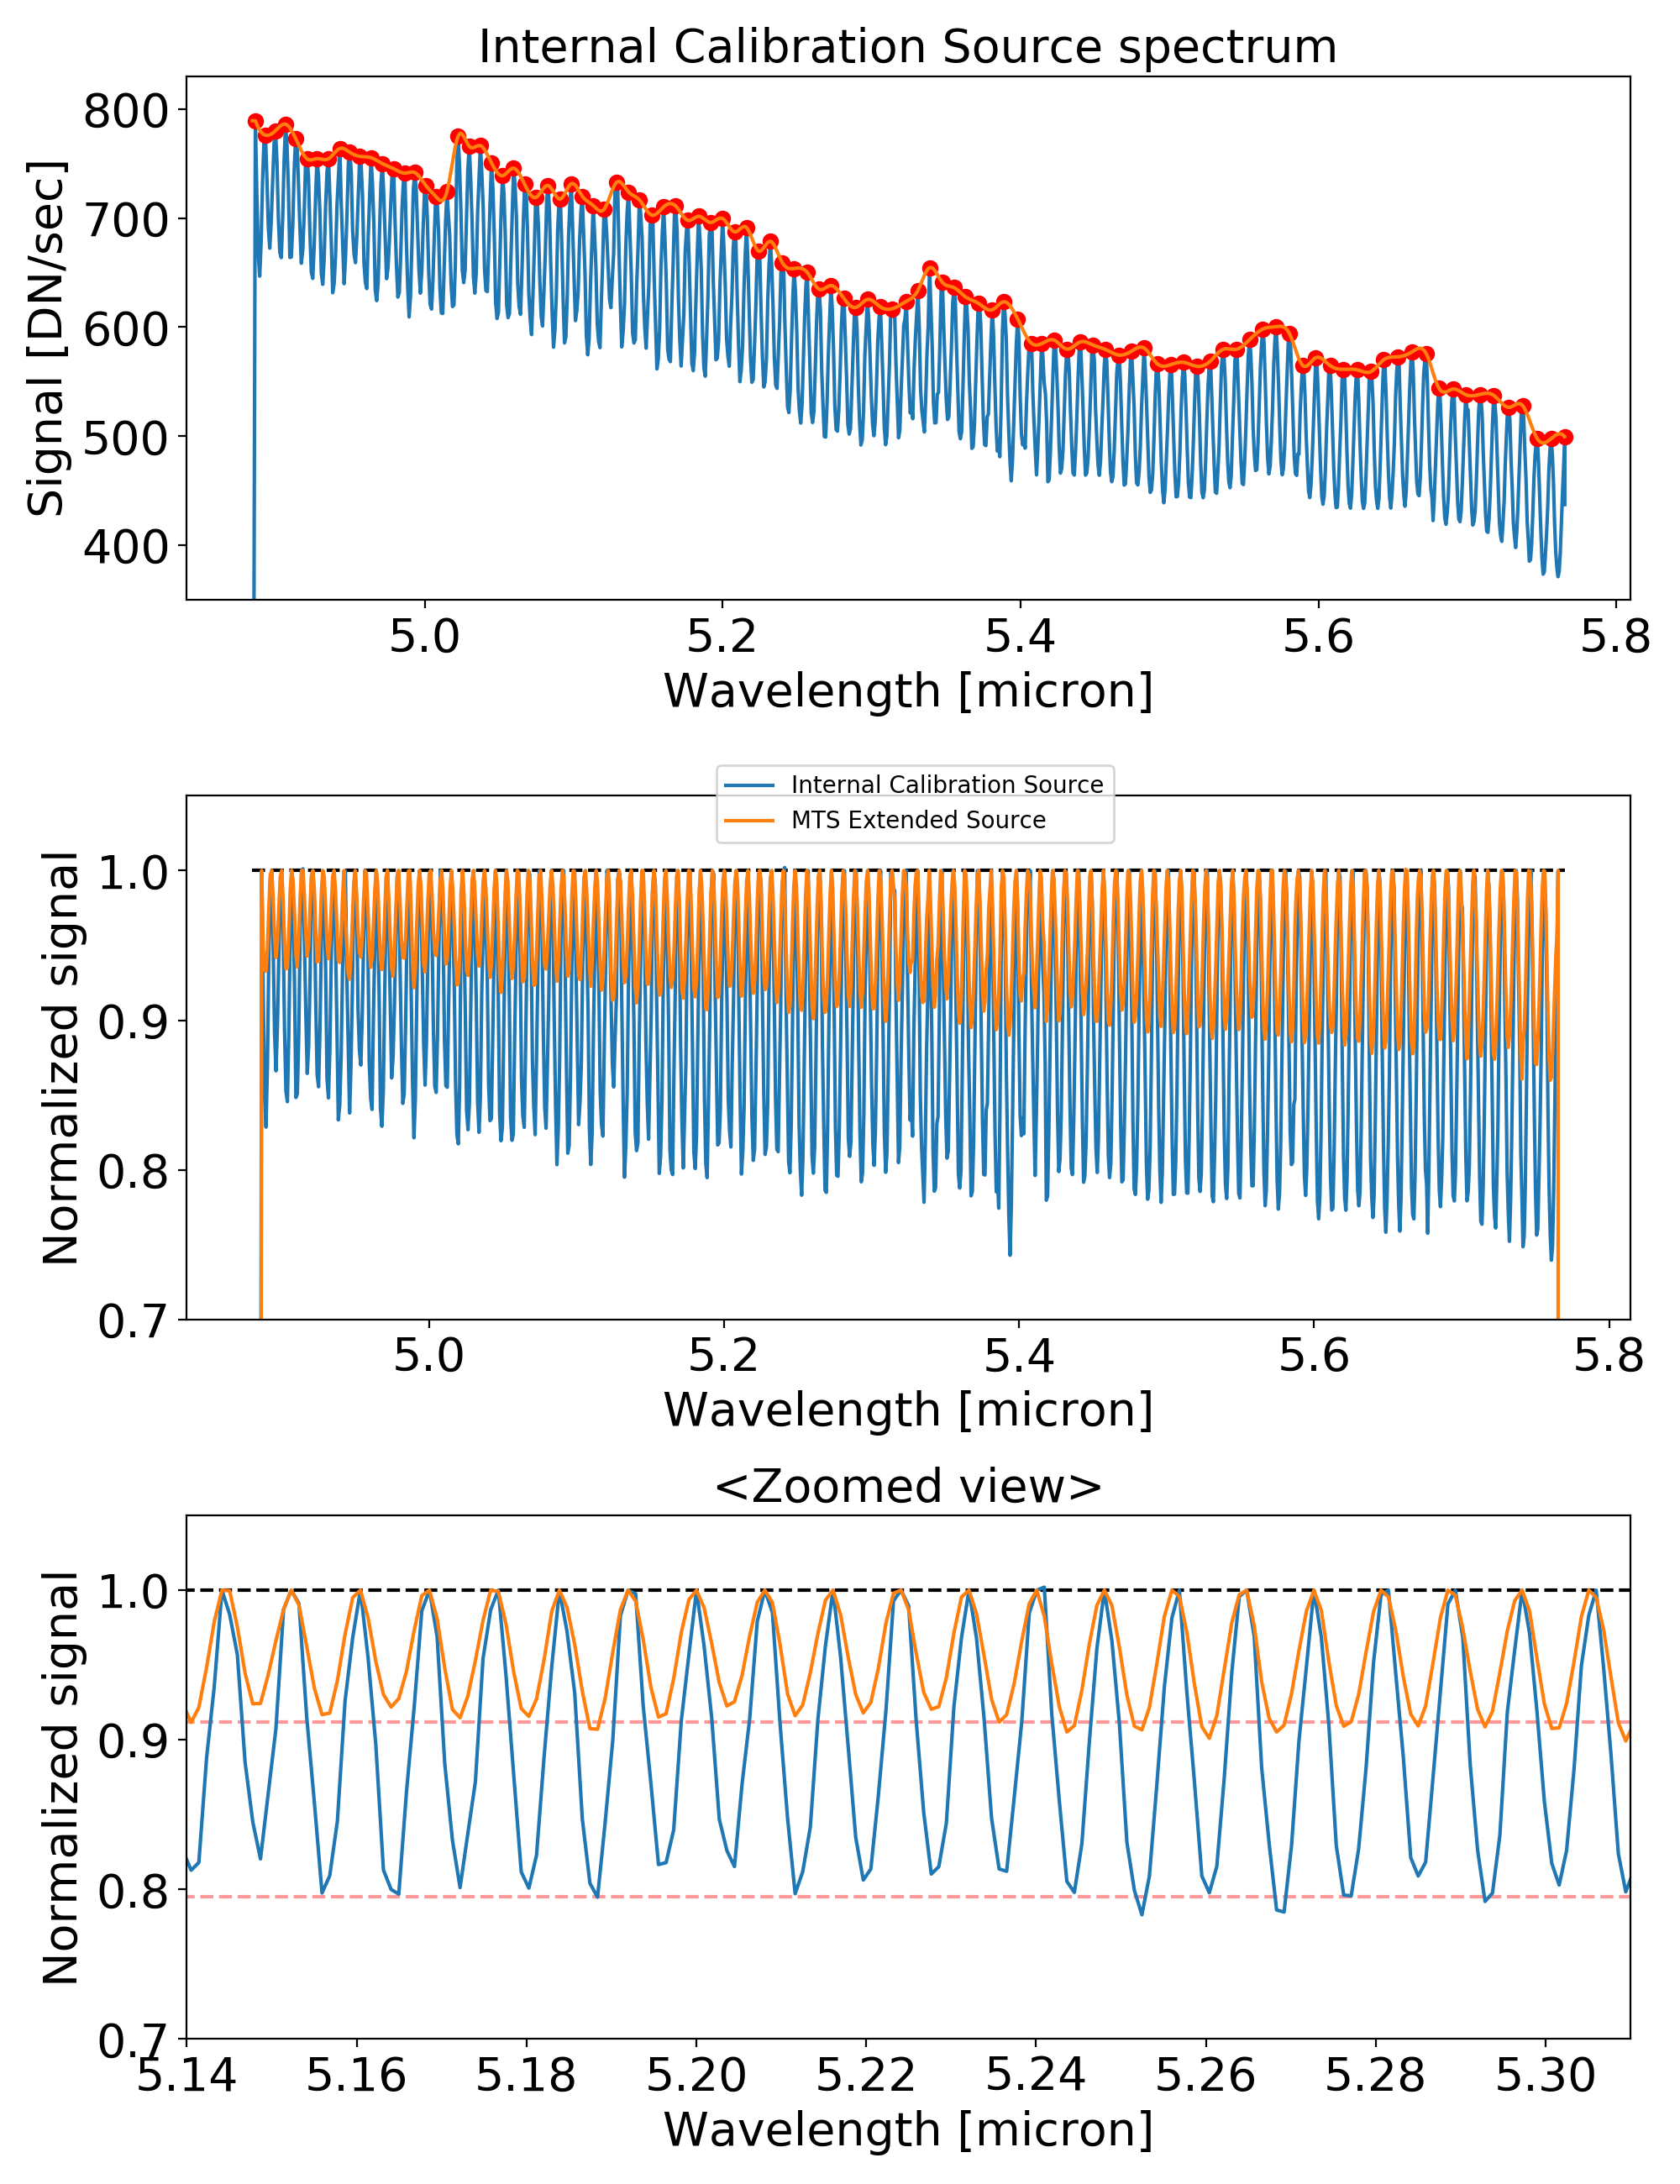

In [53]:
fig,axs = plt.subplots(3,1,figsize=(10,13))
axs[0].set_title('Internal Calibration Source spectrum')
axs[0].plot(lambdaMap[ypos_p,xpos_p][sel],intcal_source_norm[0])
axs[0].plot(lambdaMap[ypos_p,xpos_p][sel][intcal_source_norm[1]],intcal_source_norm[0][intcal_source_norm[1]],'ro')
axs[0].plot(lambdaMap[ypos_p,xpos_p][sel],intcal_source_norm[2])
axs[0].set_ylim(350,830)
axs[0].set_ylabel('Signal [DN/sec]')
for plot in range(1,3):
    axs[plot].plot(lambdaMap[ypos_p,xpos_p][sel],intcal_source_norm[0]/intcal_source_norm[2],label='Internal Calibration Source')
    axs[plot].plot(lambdaMap[ypos_p,xpos_p][sel],ext_source_norm[0]/ext_source_norm[2],label='MTS Extended Source')
    axs[plot].hlines(1,4.88,5.77,linestyle='dashed')
    axs[plot].set_ylim(0.7,1.05)
    axs[plot].set_ylabel('Normalized signal')
axs[1].legend(loc='upper right',bbox_to_anchor=(0.65,1.08),fontsize=10)
axs[2].hlines([0.795,0.912],4.88,5.77,'r',alpha=0.4,linestyle='dashed')
axs[2].set_xlim(5.14,5.31)
axs[2].set_title('<Zoomed view>')
for plot in range(3): axs[plot].set_xlabel('Wavelength [micron]')
plt.tight_layout()

### Remarks:
* The position of the fringe peaks matches between the internal calibration source fringes and the MTS extended source fringes.
* The fringe transmission of the internal calibration source is 10% larger in amplitude compared to the extended source fringe transmission. This results from a difference in fringe contrast. It appears that the extended source fringes are more washed out compared to the internal calibration source fringes.
* Both fringe patterns increase in amplitude from the lower wavelengths to the higher wavelengths (from one side of the detector to the other).

## Conclusions:  
* The internal calibration source spectrum has spatial structure to it which is wavelength-independent. The spatial structure is not caused by detector defects, for the simple reason that the structure we see "follows" the curvature of illuminated pixels on the detector, as illustrated in Test 1.
* Although the slices appear to remain at the same location between test campaigns, in the CV3 campaign the most illuminated pixels seem to be offset compared to those of the FM and OTIS test campaign. We are talking about a 1 to 2 pixel offset for the CV3 observation towards the right (in detector x-coordinates).
* Non-illuminated pixels in the internal calibration observations have non-zero signal. This one is presumably caused by background emission and/or straylight. Unexpectedly however the signal level of the non-illuminated pixels of the FM test campaign observation is lower than that in the CV3 and OTIS test campaigns.
* Applying the available straylight correction to the observations (with the default parameters) does not correct for the difference in signal of the non-illuminated pixels. The correction appears to increase however the difference in the in-slice signal between test campaigns.
* The high-frequency component of the internal calibration source matches the frequency of the MTS extended source.
* The contrast of the internal calibration source fringes is much higher than the MTS extended source fringes. Presumably the latter is affected by an additional angle-averaging process compared to the former (i.e. the fringes are more washed out).
  
## Follow-up question:  
What could be causing the difference in contrast between the fringes of the MIRI internal calibration source and that of the MTS extended source?